# Testbed for dynamic foraging models

<font size=3>Here I'm trying to outline  a simple framework that summarizes the dynamic foraging models in the literature (still under developing). I hope this can facilitate our understanding as well as our programming.

<img src="Models.png" />

<font size=3>See below (and the source code) for details.<br><font color=red>Red texts: I'm not sure.</font>

---


# Play with different foraging models (parameters yet to be optimized)

Preparation

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from foraging_testbed_simulate import *

# Try to open parallel pools (needs multiprocessing package)
try:
    n_worker = int(mp.cpu_count()/2)  # Optimal number = number of physical cores
    pool = mp.Pool(processes = n_worker)
except:
    pool = ''
    
# Parameter settings
n_trials = 1000
n_repetitions = 50

## 1. Special foragers: Random, AlwaysLEFT, IdealGreedy
### 1.1. A random forager
    

<font size=3>Note that even a random forager can achieve a foraging efficiency ~77%!<br>Foraging efficiency is defined as the actual mean reward rate divided by the averaged combined baiting probability (Corrado et al. 2005).

apply_async: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.48it/s]

--- apply_async finished in 3.2373 s---


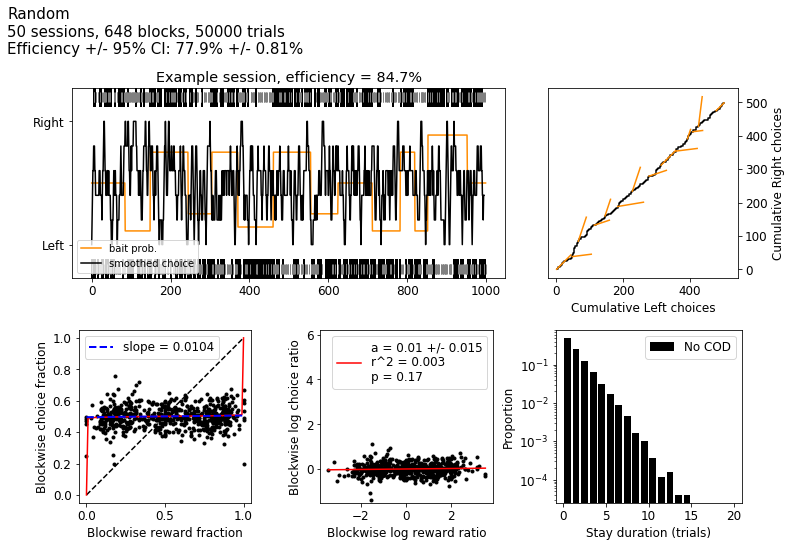

In [2]:
bandit = Bandit(forager = 'Random', n_trials = n_trials)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 1.2.  A forager with extreme bias
<font size=3>    Efficiency ~ 50% (see Corrado et al. 2005)

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 570.99it/s]

--- apply_async finished in 0.880658 s---


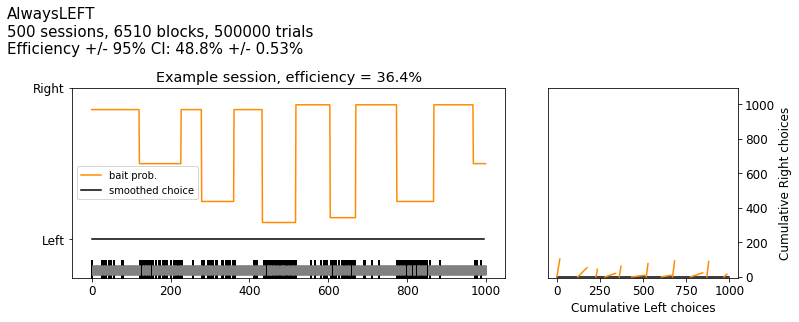

In [3]:
bandit = Bandit(forager = 'AlwaysLEFT', n_trials = n_trials)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 1.3 An ideal forager
    

<font size=3>    A forager who **knows** the underlying baiting probability and always chooses the **greedy** option.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 231.35it/s]

--- apply_async finished in 2.16525 s---


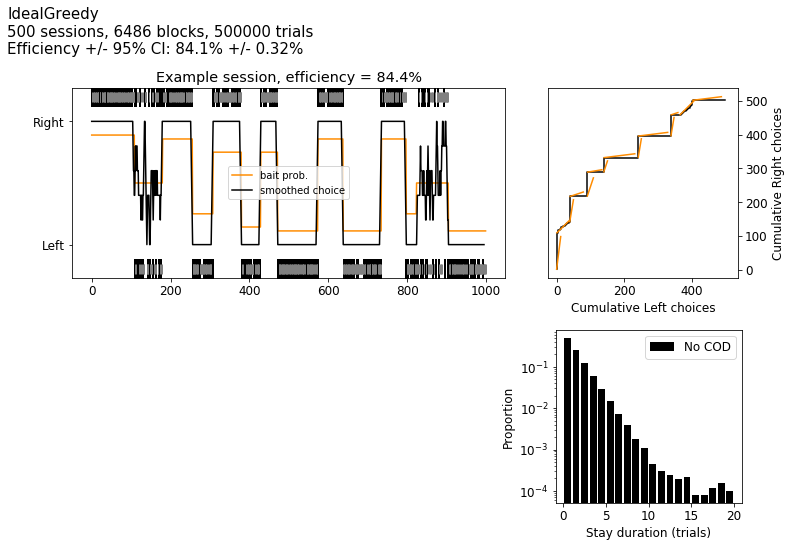

In [4]:
bandit = Bandit(forager = 'IdealGreedy')
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

---
## 2. LNP-like foragers: Sugrue2004, Corrado2005, and Iigaya2019

<font size=3> They share the same structure:

**Income History -> Linear Filter (single/multi- exp.) -> Mapping Function (fractional/softmax) -> Poisson choice probability**<br><br>

### 2.1 [Sugrue 2004: Income history + Single exponential + Fractional + Choice probability](https://science.sciencemag.org/content/304/5678/1782.long)

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 167.11it/s]

--- apply_async finished in 2.99603 s---


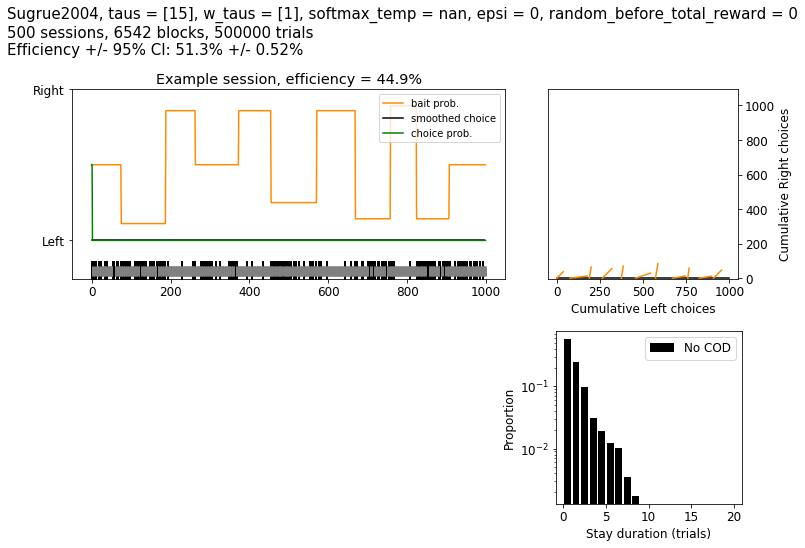

In [5]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=5>**It fails...**</font>

<font size=3> Seems that the green curve converges to 0 or 1 quickly, and the forager never explores. This is because Sugrue2004 uses a "fractional" operation, i.e., $p_i = I_i/\sum(I_i)$, which becomes 0 or 1 immediately after the forager receives the **first reward** in a session. The authors did not talk about this in their paper. Instead, they claimed that their "simple model has only one tuned parameter". But I think we need an explicit mechanism to encourage exploration here. <font color='red' size=4>**(Did I make any mistakes? Please help...)**</font> 

A simple way could be using the epsilon-rule (see [Sutton&Barto's RL book](http://www.incompleteideas.net/book/RLbook2018.pdf), p.28). Therfore, I introduced a free parameter `epsilon` to indicate the probability with which the forager makes random guesses  on each trial (kind of "lapse rate"). Here's the result of `epsilon` = 0.15. Looks much better.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 161.04it/s]

--- apply_async finished in 3.10874 s---


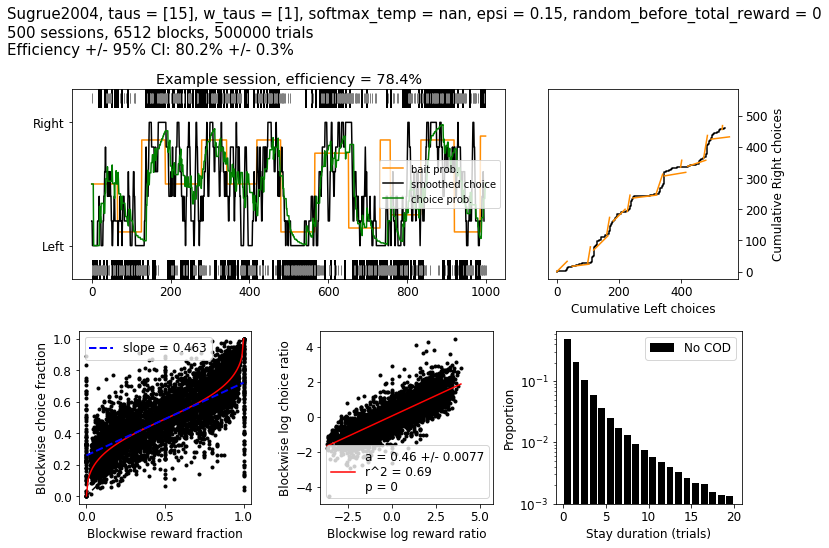

In [6]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, epsilon = 0.15, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 2.2 [Corrado2005: Income history + Double-exponential + Softmax + Choice probability](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1389782)
<font size=3> In contrast to Sugrue 2004, Corrado 2005 uses a double-exponential filter and `softmax` rather than `fractional` in the step of mapping value estimation to choice probability.

Note that `softmax` here is equivalent to *difference + sigmoid non-linearity* described in their paper.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 160.40it/s]

--- apply_async finished in 3.12219 s---


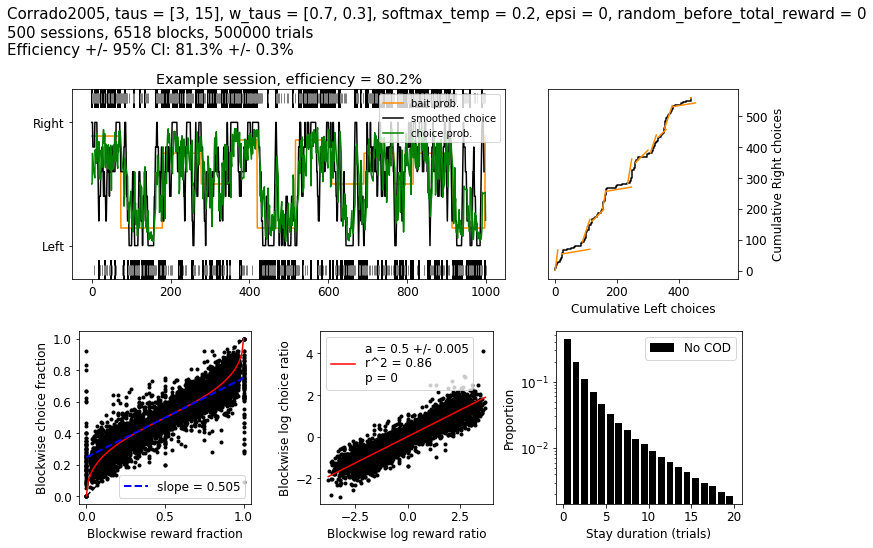

In [7]:
bandit = Bandit(forager = 'Corrado2005', taus = [3, 15], w_taus = [0.7, 0.3], softmax_temperature = 0.2, epsilon = 0, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=3> Corrado2005 does **NOT** require `epsilon` > 0, because its `softmax` mapping function prevents $p_i$ from reaching exactly 0 or 1, thus encouraging exploration. 

### 2.3 [Iigaya2019: Income history + Double-/Triple- exponential + Fractional + Choice probability](https://www.nature.com/articles/s41467-019-09388-3)
<font size=3> In Iigaya et al. 2019, they used *fractional mapping* again, like Sugrue2004. So it will not work without an explicit exploration mechanism.

<font color='red' size=4>**(again, am I right?)**</font>

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 166.50it/s]

--- apply_async finished in 3.00802 s---


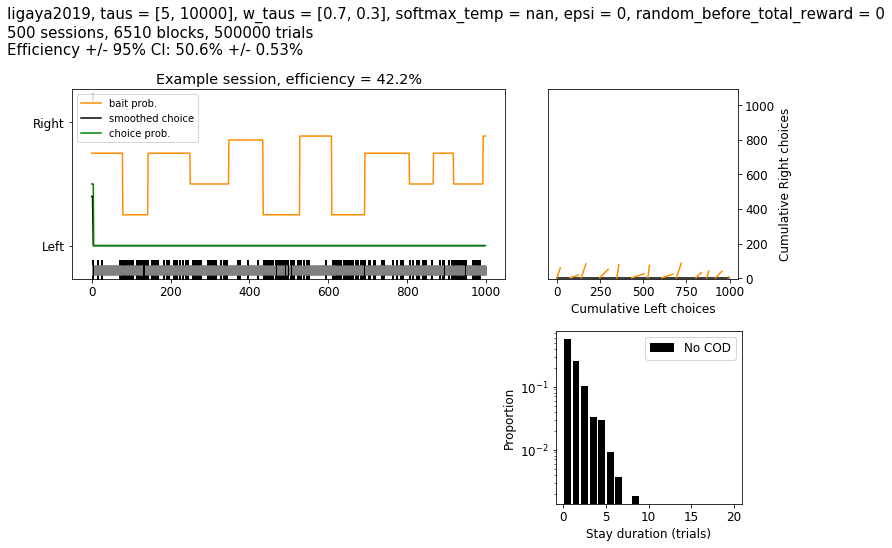

In [8]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.7, 0.3], n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool); 

 <font size=3> To rescue this, we may add a small `epsilon`, just like in Sugrue 2004.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 161.07it/s]

--- apply_async finished in 3.10929 s---


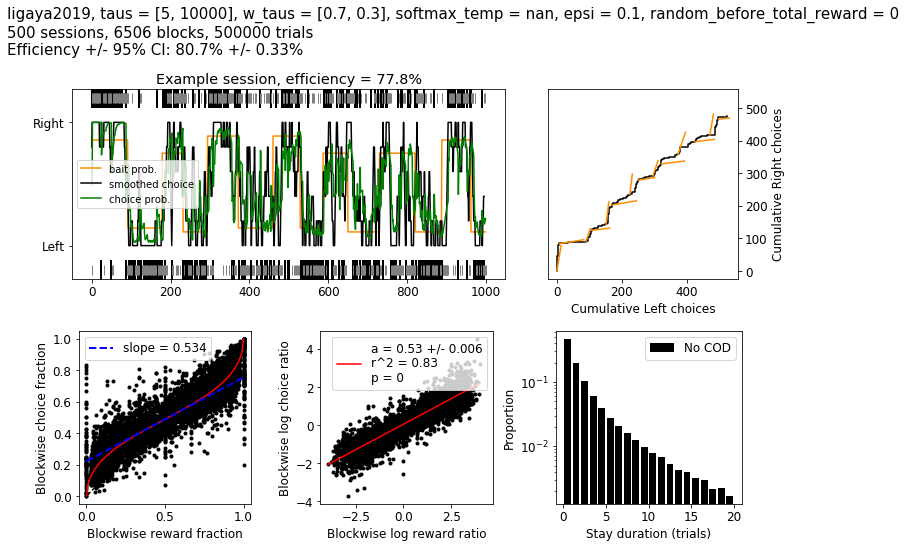

In [9]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.7, 0.3], epsilon = 0.1, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);  

<font size=3> Or, alternatively, we may add an **initial exploration period** to encourage exploration at the begining of a session, as suggested in [Marton's code](https://github.com/rozmar/DataPipeline/blob/3811ab7c8e2062d7410bf3a8fb92e75313613a9b/Behavior/foraging_model/foraging_model.py#L38). The forager makes random choices before the total number of rewards exceeds `random_before_total_reward`.

Magically, with this short **initial exploration period** (20, for example), the forager can do a decent job in the rest of a long session (2000 trials, for example):

apply_async: 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.52it/s]

--- apply_async finished in 6.45427 s---


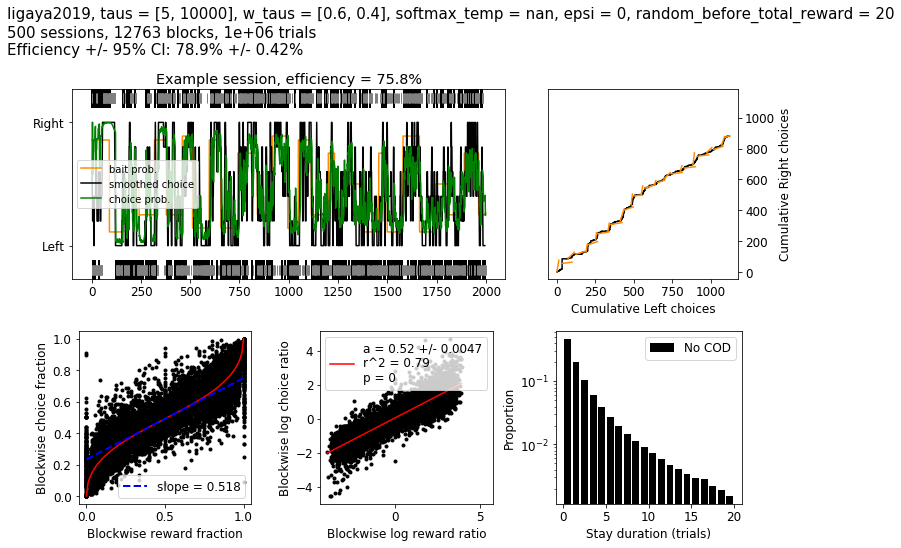

In [10]:
bandit = Bandit(forager = 'Iigaya2019', taus = [5,10000], w_taus = [0.6, 0.4], random_before_total_reward = 20, n_trials = 2000) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);  

<font size=3>My intuition of why this works is that the extremely long time constant (e.g., 10000) tends to have balanced contributions to the two choices in a long run, thus adding a small baseline probability to each of them (corresponding to `epsilon/2` in the $\epsilon$-method). But it needs some time to build up this balance, and this is why we need the initial forced exploration period to kick it off.

Consistent with this notion, `random_before_total_reward` has **no persistent effect without the help of a long time constant**, as shown in the case of Sugrue 2004:

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 165.29it/s]

--- apply_async finished in 3.02895 s---


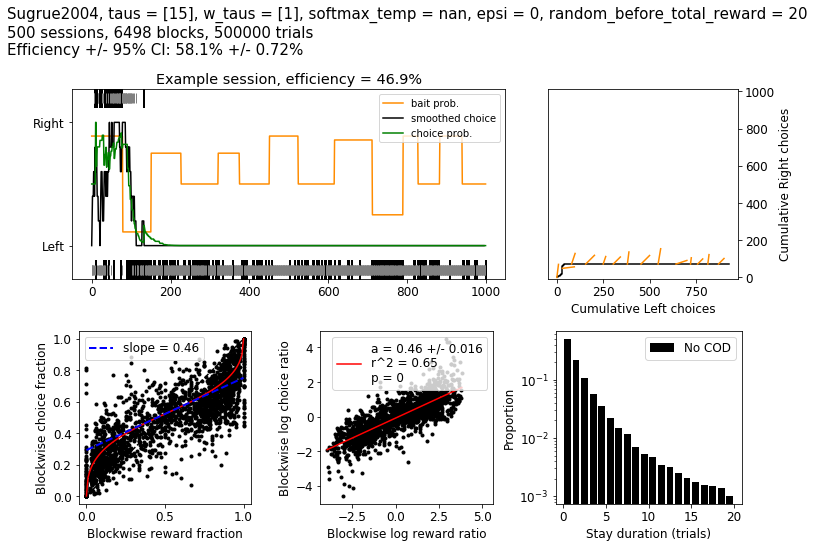

In [20]:
bandit = Bandit(forager = 'Sugrue2004', taus = 15, epsilon = 0, random_before_total_reward = 20, n_trials = n_trials) 
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

<font size=3> Taken together, exploration is essential for dynamic foraging. The key idea of exploration is to prevent $p_i$ from getting trapped at 0 or 1.<br> We have several options:<br>
1. Use `epsilon` to add a (hard) baseline probability, such that $\bar{p_i}>\epsilon/2$ (Sugrue2004)
2. Use `softmax` to add a (soft) baseline probability (Corrado2005)
3. Use a long time constant together with an initial exploration period (Iigaya2019) <br>

(If I'm the subject, I would choose option 1, because it's much simpler to just be lazy than to remember a long reward history!!)<br>
    
Again, I don't know why neither Sugrue et al. 2004 nor Iigaya et al. 2019 has discussed about this... <font color='red' size=3> Did I miss something?


## 3. RL-like foragers: SuttonBartoRLBook, Bari2019, and Hattori2019
<font size=3>All of them are reinforcement-learning-style foragers in the sense that they estimate **action values** $Q_i$. I summarized their algorithms into a general form <font color=red>(please check this)</font>:<br>    
    &emsp;&emsp;$Q_{ch}(t+1) = (1-\delta_{ch})*Q_{ch}(t) + \alpha_{reward}*(reward - Q_{ch}(t))$<br>
    &emsp;&emsp;$Q_{unch}(t+1) = (1-\delta_{unch})*Q_{unch}(t) $
    
where $Q_{ch}$ and $Q_{unch}$ are *action values* of the chosen and unchosen options, respectively; $\delta$s are their corresponding *forgetting rates*, and $\alpha_{reward}$ is a reward-dependent *learning rate*; $reward\in\{0,1\}$.<br><br>
Specifically:<br>
<font size=3>&emsp;For ['SuttonBartoRLBook'](http://www.incompleteideas.net/book/RLbook2018.pdf),&emsp; $\delta_{ch} = \delta_{unch} = 0, \alpha_0 = \alpha_1$,&emsp;&emsp;&emsp;&emsp;&emsp;followed by `epsilon-greedy`<br>
    &emsp;For ['Bari2019'](https://www.ncbi.nlm.nih.gov/pubmed/31280924),&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\delta_{ch} = \delta_{unch} = 1-\zeta > 0, \alpha_0 = \alpha_1$&emsp;&emsp;&emsp;followed by `softmax-Poisson`<br>
    &emsp;For ['Hattori2019'](https://www.ncbi.nlm.nih.gov/pubmed/31080067), &emsp;&emsp;&emsp;&emsp;&emsp;$\delta_{ch}=0, \delta_{unch}=\delta, \alpha_0 \ne \alpha_1$&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;followed by `softmax-Poisson`<br>
    
Note that updating $Q$ as above is quite similar to applying an exponential filter in LNP-like foragers, with an `effective time constant` of<br>$$\tau_{eff}=-\frac{1}{ln(1-(\alpha+\delta))}\approx\frac{1}{\alpha+\delta}$$
However, RL-like foragers compute local **return** rather than local **income** because they only actively update $Q_{ch}$ (at least when $\delta_{unch}=0$). See discussion in Corrado et al. 2005.

### 3.1 'SuttonBartoRLBook'
<font size=3>Modified from the solution to the `bandit` problem in Chapter 2 of their [RL book](http://www.incompleteideas.net/book/RLbook2018.pdf).

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 134.51it/s]

--- apply_async finished in 3.72212 s---


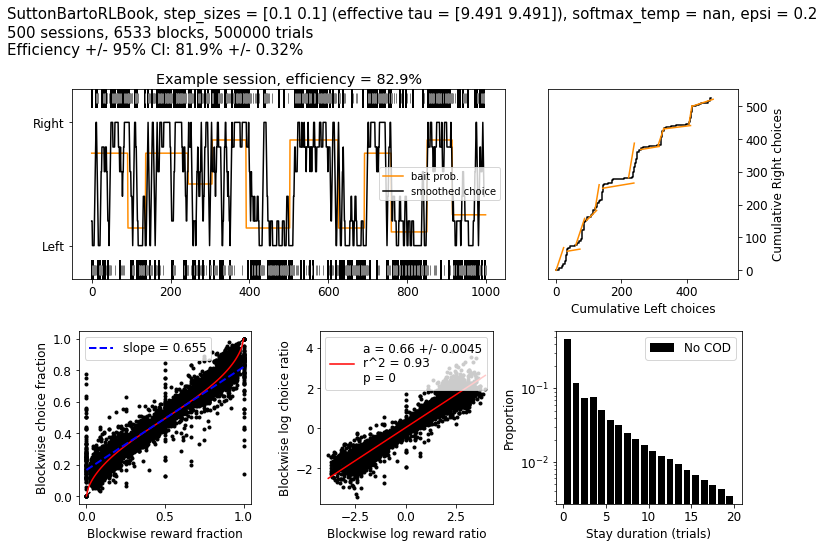

In [12]:
bandit = Bandit(forager = 'SuttonBartoRLBook',step_sizes = 0.1, epsilon = 0.2, n_trials = n_trials)
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 3.2 'Bari2019'

<font size=3>The outcome is very sensitive to `softmax_temperature`.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.26it/s]

--- apply_async finished in 3.22445 s---


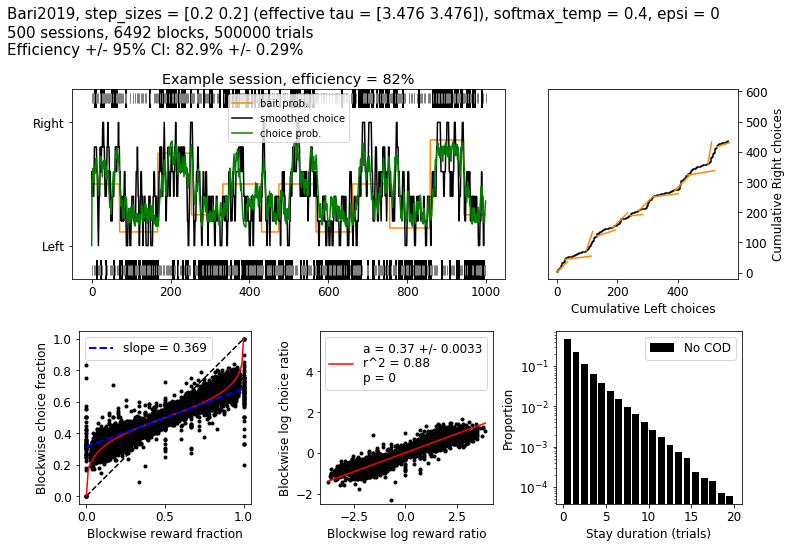

In [13]:
bandit = Bandit(forager = 'Bari2019', step_sizes = 0.2, forget_rate = 0.05, softmax_temperature = 0.4,  epsilon = 0, n_trials = n_trials)  
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

### 3.3 'Hattori2019'

<font size=3>The most volatile (and thus also the most efficient) one in the RL-like foragers.

apply_async: 100%|██████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 155.98it/s]

--- apply_async finished in 3.20947 s---


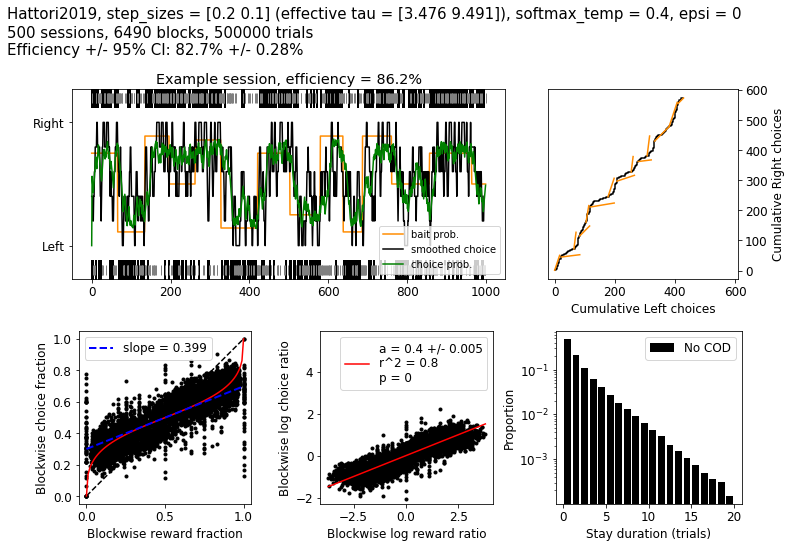

In [14]:
bandit = Bandit(forager = 'Hattori2019', epsilon = 0,  step_sizes = [0.2, 0.1], forget_rate = 0.05, softmax_temperature = 0.4, n_trials = n_trials)   
run_sessions_parallel(bandit, n_reps = n_repetitions, pool = pool);

---

# Parameter Scan

## Figure 2C in Sugrue et al., 2004

<font size=3>Let's first try `epsilon = 0.15`

apply_async: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 163.85it/s]

--- apply_async finished in 18.3595 s---


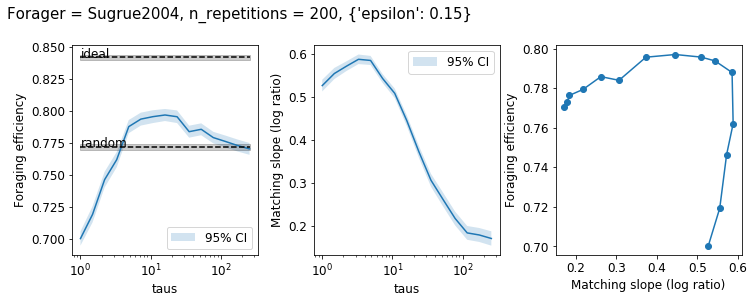

In [15]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,15))}
para_scan('Sugrue2004', para_to_scan, epsilon = 0.15, n_reps = 200, pool = pool);

<font size=3> The foraging efficiency drops dramatically when $\tau$ is small, which is not the case in their paper. As discussed previously, this result should depend on `epsilon`. So let's try `epsilon = 0.5` instead.

apply_async: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 159.19it/s]

--- apply_async finished in 18.9111 s---


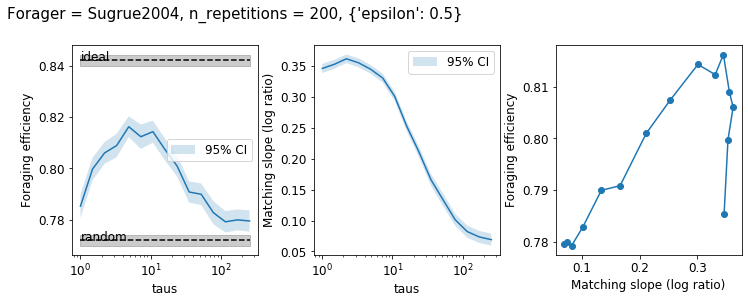

In [16]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,15))}
para_scan('Sugrue2004', para_to_scan, epsilon = 0.5, n_reps = 200, pool = pool);

<font size=3> Now the left panel looks more similar to Sugrue's Figure 2C.

<font size=3> We can also try a 2-D para scan.

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 165.96it/s]

--- apply_async finished in 30.1793 s---


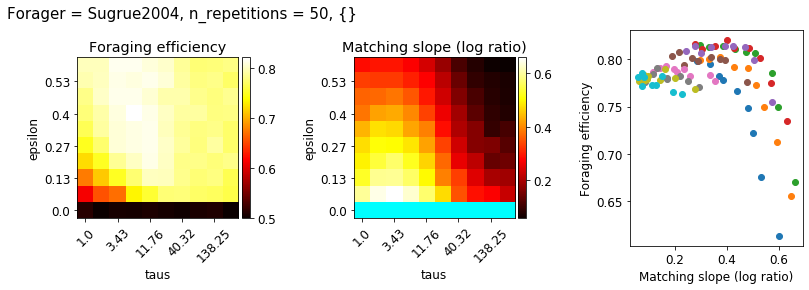

In [17]:
para_to_scan = {'taus': np.power(2, np.linspace(0,8,10)),
                'epsilon': np.linspace(0,0.6,10),
                }
para_scan('Sugrue2004', para_to_scan, n_reps = 50, pool = pool);

<font size=3>Note that better matching does not necessarily lead to larger foraging efficiency, as suggested by Iigaya et al 2019. However, the matching slope is only ~0.3 for the best $\tau$, which seems impossible to fit Sugrue's monkey data...<br>
    
    
<font size=5 color=red>Again, did I miss something?

## Figure 11B of Corrado et al 2005

apply_async: 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 164.81it/s]

--- apply_async finished in 30.3904 s---


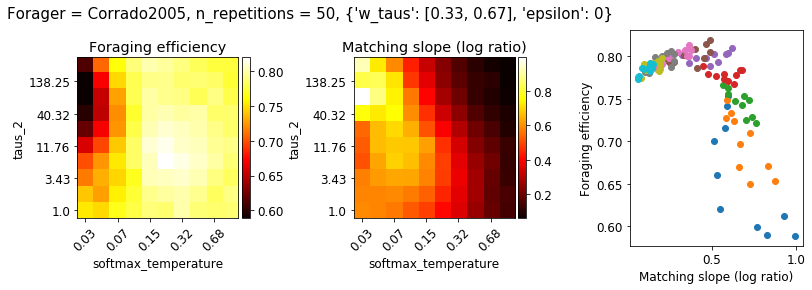

In [18]:
taus = [[2, tau_2] for tau_2 in np.power(2, np.linspace(0,8,10))]
para_to_scan = {'softmax_temperature': np.power(10, np.linspace(-1.5,0,10)),
                'taus': taus,
                }
para_scan('Corrado2005', para_to_scan, w_taus = [0.33, 0.67],  epsilon = 0, n_reps = 50, pool = pool);

<font size=3>Looks great! Thanks to `softmax`, there is no `epsilon` issue in this paper)

## Figure 3d and 3e of Iigaya et al, 2019

apply_async: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 165.87it/s]

--- apply_async finished in 12.0679 s---


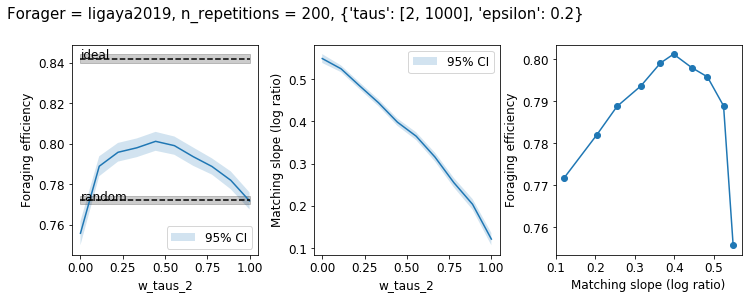

In [19]:
w_taus = [[1-w_slow, w_slow] for w_slow in np.linspace(0,1,10)]
para_to_scan = {'w_taus': w_taus}
para_scan('Iigaya2019', para_to_scan, taus = [2,1000],  epsilon = 0.2, n_reps = 200, pool = pool);

<font size=3>Looks similar to their figures. However, again, my plots here depend on `epsilon`.

<font size=5>More to come...

---
# To-do list

1. Add more models
    - Lau 2005 (Reward history + choice history + softmax)
    - Saki 2008 (actor-critic)
    - Standard Q-learning from Sutton and Barto RL book (full state representation)
2. Add COD or switch cost (switch cost = COD?)
    - The model knows COD/switch cost
    - The model has to figure out COD/switch cost by itself
    - Marginal value theorem
3. Parameter optimization
    - To optimize model's performance
    - To fit animals' behavior 
5. Baited vs unbaited?
6. Multiple choices or even continuous choice?
7. Model-based?